# Statistical Analysis - Shayan Rasheed

This document contains an evaluation of LLM translation using a French-English Dataset.

### Dependencies

In [ ]:
! pip install datasets

In [ ]:
! pip install rouge

In [ ]:
! pip install bert-score

In [99]:
import requests
import pandas as pd
import time
import seaborn as sns

from datasets import load_dataset

import sacrebleu
from rouge import Rouge
import bert_score

import matplotlib.pyplot as plt

from transformers import MarianMTModel, MarianTokenizer

## Loading and preparing the dataset

In [4]:
french_dataset = load_dataset("Helsinki-NLP/opus_books", 'en-fr')

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [44]:
fr_df = pd.DataFrame(french_dataset['train']['translation'])

fr_df.columns = ['en', 'fr']

fr_df = fr_df.iloc[100:200]
display(fr_df)

,en,fr
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...
...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche..."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é..."


## Translating dataset using Marian MT

In [38]:
model_name = "Helsinki-NLP/opus-mt-fr-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [116]:
def infer(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=1024)

    translated_ids = model.generate(**inputs)

    translated_sentence = tokenizer.decode(translated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return translated_sentence

In [45]:
def apply_infer(row):
    output = infer(row['fr'])
    return output

fr_df['LLM_Translation'] = fr_df.apply(apply_infer, axis=1)

display(fr_df)

,en,fr,LLM_Translation
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...
...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the..."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...


## Evaluating LLM accuracy using BLEU SCORE

In [100]:
def compute_bleu(row):
    reference = [row['en']]
    candidate = [row['LLM_Translation']]
    return sacrebleu.corpus_bleu(candidate, [reference]).score

fr_df['bleu_score'] = fr_df.apply(compute_bleu, axis=1)
display(fr_df)

,en,fr,LLM_Translation,bleu_score,rouge_score
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta...",30.982990,"{'rouge-1': {'r': 0.6216216216216216, 'p': 0.5..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ...",23.706174,"{'rouge-1': {'r': 0.5769230769230769, 'p': 0.6..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.,19.070828,"{'rouge-1': {'r': 0.42857142857142855, 'p': 0...."
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...,28.889424,"{'rouge-1': {'r': 0.7222222222222222, 'p': 0.7..."
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...,6.734395,"{'rouge-1': {'r': 0.38461538461538464, 'p': 0...."
...,...,...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,...",29.415187,"{'rouge-1': {'r': 0.5238095238095238, 'p': 0.5..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis...",14.587229,"{'rouge-1': {'r': 0.4827586206896552, 'p': 0.4..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the...",24.018433,"{'rouge-1': {'r': 0.35294117647058826, 'p': 0...."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...,7.850507,"{'rouge-1': {'r': 0.5277777777777778, 'p': 0.5..."


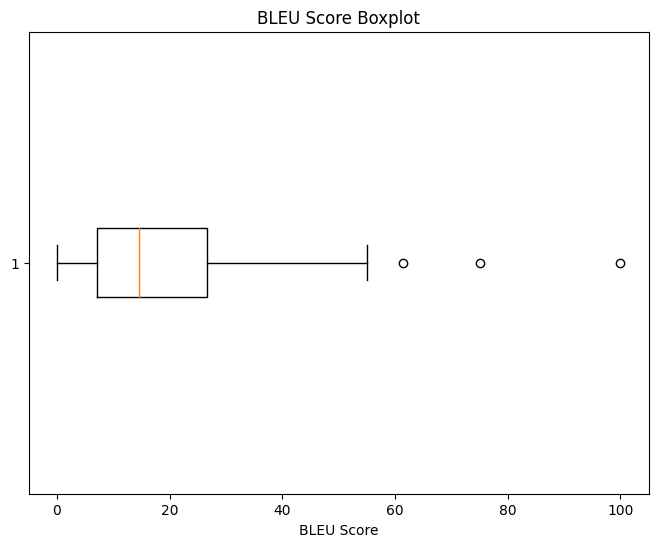

In [101]:
plt.figure(figsize=(8, 6))
plt.boxplot(fr_df['bleu_score'], vert=False)
plt.title('BLEU Score Boxplot')
plt.xlabel('BLEU Score')
plt.show()

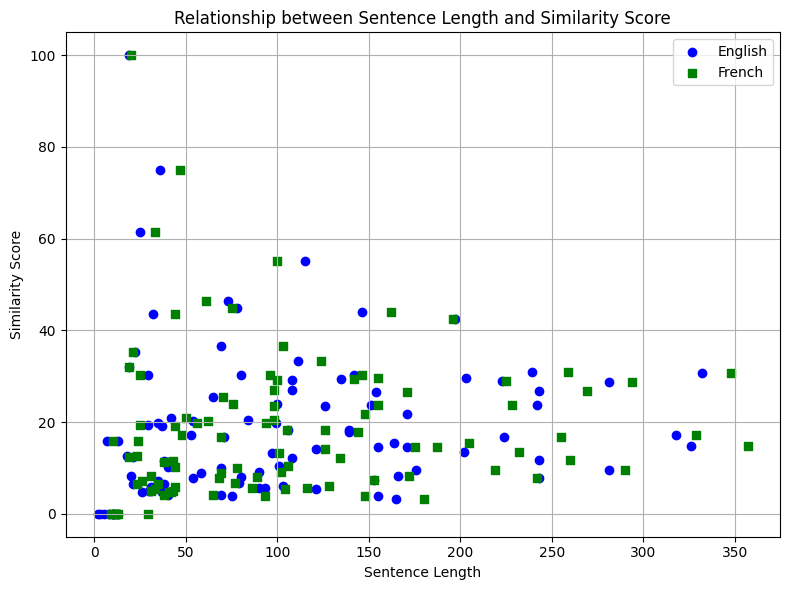

In [102]:
english_lengths = [len(row['en']) for index, row in fr_df.iterrows()]
french_lengths = [len(row['fr']) for index, row in fr_df.iterrows()]


plt.figure(figsize=(8, 6))
plt.scatter(english_lengths, fr_df['bleu_score'], label='English', color='blue', marker='o')
plt.scatter(french_lengths, fr_df['bleu_score'], label='French', color='green', marker='s')


plt.xlabel('Sentence Length')
plt.ylabel('Similarity Score')
plt.title('Relationship between Sentence Length and Similarity Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [121]:
fr_df['bleu_score'].median()

14.67061544276568

In [122]:
fr_df['bleu_score'].mean()

18.523374603407348

### Analysis of BLEU Results

The overall results of the BLEU Scores for the LLM Translation were relatively low. For instance, consider the following example:

In [117]:
fr_df['en'].iloc[1]

'When it was quite dark, and the dogs of the neighbouring farm began to howl and a light was seen at the window of our little kitchen, then I went home.'

In [118]:
fr_df['LLM_Translation'].iloc[1]

'When it was dark, the dogs of the nearby farm began to scream and the tile of our little kitchen was silting, I finally came home.'

In [119]:
fr_df['bleu_score'].iloc[1]

23.706173812439708

As you can see, the meaning of the LLM generated translation and the reference translation are similar, but the wording is slightly different. This results in fewer matching n-grams, which is what the BLEU Score is computed based on. This is the cause of the lower BLEU Score for the translations overall.

## Computing ROUGE

In [60]:
def compute_rouge(row):
    prediction = row['LLM_Translation']
    reference = row['en']

    rouge = Rouge()
    scores = rouge.get_scores(prediction, reference)
    return scores[0]

In [61]:
fr_df['rouge_score'] = fr_df.apply(compute_rouge, axis=1)
display(fr_df)

,en,fr,LLM_Translation,bleu_score,rouge_score
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta...",1.103598,"{'rouge-1': {'r': 0.6216216216216216, 'p': 0.5..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ...",1.693410,"{'rouge-1': {'r': 0.5769230769230769, 'p': 0.6..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.,4.767707,"{'rouge-1': {'r': 0.42857142857142855, 'p': 0...."
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...,1.031202,"{'rouge-1': {'r': 0.7222222222222222, 'p': 0.7..."
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...,2.839839,"{'rouge-1': {'r': 0.38461538461538464, 'p': 0...."
...,...,...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,...",1.579046,"{'rouge-1': {'r': 0.5238095238095238, 'p': 0.5..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis...",1.304348,"{'rouge-1': {'r': 0.4827586206896552, 'p': 0.4..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the...",2.923638,"{'rouge-1': {'r': 0.35294117647058826, 'p': 0...."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...,2.322403,"{'rouge-1': {'r': 0.5277777777777778, 'p': 0.5..."


### ROUGE-1 Scores

In [90]:
precision_scores = [row['rouge-1']['p'] for row in fr_df['rouge_score']]
recall_scores = [row['rouge-1']['r'] for row in fr_df['rouge_score']]
f1_scores = [row['rouge-1']['f'] for row in fr_df['rouge_score']]

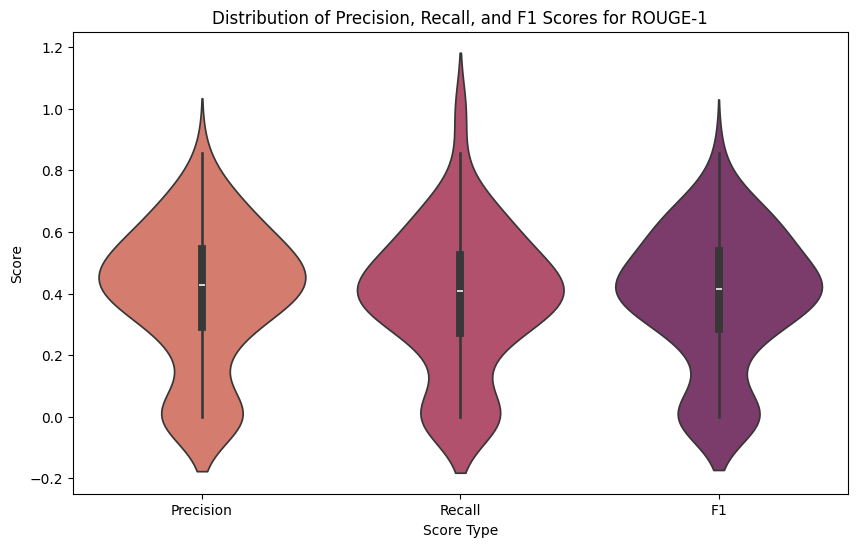

In [91]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="flare", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for ROUGE-1')
plt.ylabel('Score')
plt.show()

### ROUGE-2 Scores

In [88]:
precision_scores = [row['rouge-2']['p'] for row in fr_df['rouge_score']]
recall_scores = [row['rouge-2']['r'] for row in fr_df['rouge_score']]
f1_scores = [row['rouge-2']['f'] for row in fr_df['rouge_score']]

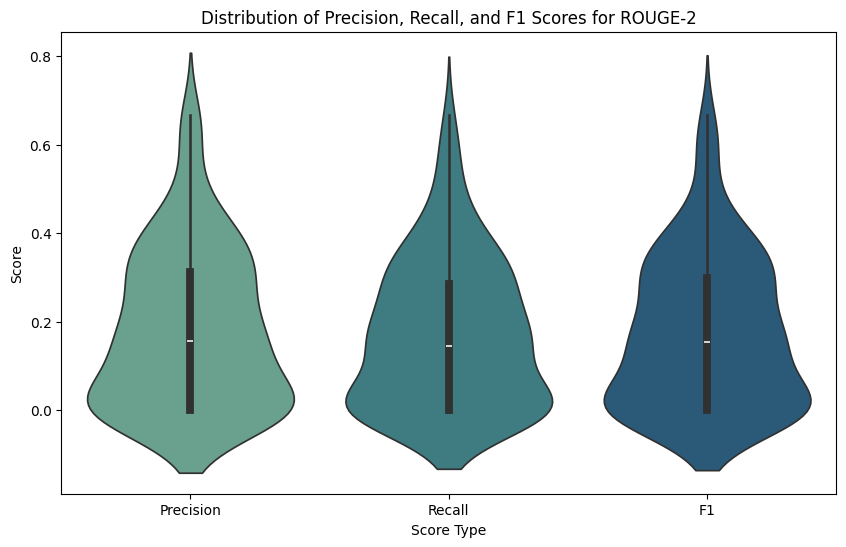

In [89]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="crest", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for ROUGE-2')
plt.ylabel('Score')
plt.show()

### ROUGE-L Scores

In [95]:
precision_scores = [row['rouge-l']['p'] for row in fr_df['rouge_score']]
recall_scores = [row['rouge-l']['r'] for row in fr_df['rouge_score']]
f1_scores = [row['rouge-l']['f'] for row in fr_df['rouge_score']]

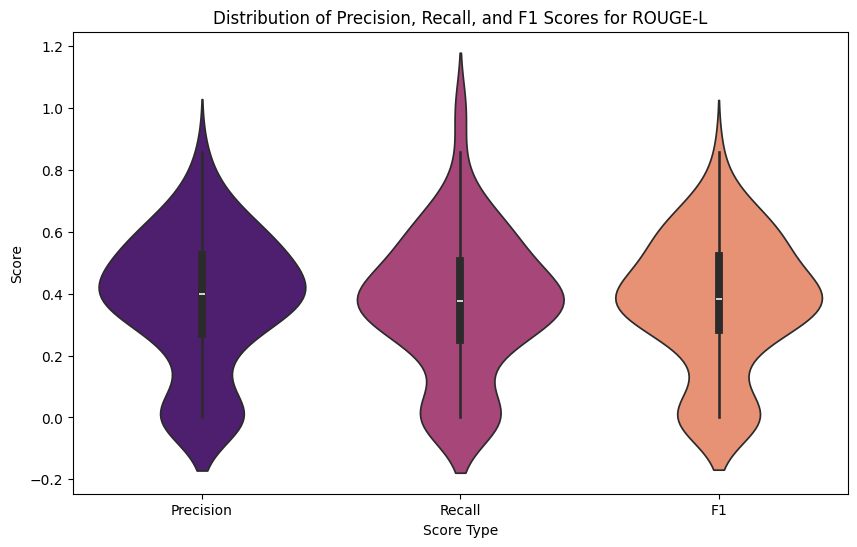

In [96]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="magma", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for ROUGE-L')
plt.ylabel('Score')
plt.show()

## Analyzing ROUGE Score

From this, we can see that the ROUGE-1 Scores were higher than that of the BLEU Scores, with medians of about 0.4 (highest is 1) for ROUGE-1 Score precision, recall, and F1; and 14 (highest is 100) for BLEU Score.

The ROUGE-1 Score measures the proportion of overlapping unigrams (single words) between the reference (ground truth) summary and the generated summary. This would explain why the ROUGE-1 Scores would be higher since the LLM Translations commonly contained similar words to that of the reference translation with some differences in word choice and/or order. As mentioned previosuly, BLEU Scores are the measure of matching n-grams, which is a much stricter measurement on how close the LLM translation is to the reference.

ROUGE-2 scores instead take bigrams into consideration, which are sequences of two adjacent words. The overall scores for ROUGE-2 was lower than ROUGE-1, but higher than BLEU. This is, again, likely due to the slight differences in wording present in the LLM Translations.

## Calculating BERT Score

In [106]:
def compute_bert(row):
    reference = [row['en']]
    candidate = [row['LLM_Translation']]
    return bert_score.score(candidate, reference, lang='en')

In [ ]:
fr_df['bert_score'] = fr_df.apply(compute_bert, axis=1)

In [112]:
display(fr_df)

,en,fr,LLM_Translation,bleu_score,rouge_score,bert_score
100,"Then, as long as there was a ray of light, I s...","Alors, tant qu’il y avait une lueur de jour, j...","So, as long as there was a light of day, I sta...",30.982990,"{'rouge-1': {'r': 0.6216216216216216, 'p': 0.5...","([tensor(0.9255)], [tensor(0.9212)], [tensor(0..."
101,"When it was quite dark, and the dogs of the ne...","Lorsqu’il faisait noir, que les chiens de la f...","When it was dark, the dogs of the nearby farm ...",23.706174,"{'rouge-1': {'r': 0.5769230769230769, 'p': 0.6...","([tensor(0.9305)], [tensor(0.9276)], [tensor(0..."
102,Mother had begun to get supper ready.,Ma mère avait commencé de préparer le repas.,My mother had begun to prepare the meal.,19.070828,"{'rouge-1': {'r': 0.42857142857142855, 'p': 0....","([tensor(0.9506)], [tensor(0.9558)], [tensor(0..."
103,"I climbed three steps of the attic stairs, sat...",Je montais trois marches de l’escalier du gren...,I climbed three steps from the stairway of the...,28.889424,"{'rouge-1': {'r': 0.7222222222222222, 'p': 0.7...","([tensor(0.9452)], [tensor(0.9336)], [tensor(0..."
104,But some one has come who has taken from me th...,Mais quelqu’un est venu qui m’a enlevé à tous ...,But someone came who took me away from all the...,6.734395,"{'rouge-1': {'r': 0.38461538461538464, 'p': 0....","([tensor(0.9453)], [tensor(0.9386)], [tensor(0..."
...,...,...,...,...,...,...
195,"At two o'clock in the afternoon next day, in t...","À deux heures de l’après-midi, le lendemain, l...","At two o'clock in the afternoon, the next day,...",29.415187,"{'rouge-1': {'r': 0.5238095238095238, 'p': 0.5...","([tensor(0.9264)], [tensor(0.9302)], [tensor(0..."
196,There is no smell of brine or tar as on a boat...,"On n’y sent pas la saumure ni le cambouis, com...","It does not smell brine or camboo, as on a fis...",14.587229,"{'rouge-1': {'r': 0.4827586206896552, 'p': 0.4...","([tensor(0.9177)], [tensor(0.9154)], [tensor(0..."
197,"As the end of the year is drawing near, the ex...","On a distribué, car la fin de l’année approche...","The composition books were distributed, as the...",24.018433,"{'rouge-1': {'r': 0.35294117647058826, 'p': 0....","([tensor(0.9296)], [tensor(0.9120)], [tensor(0..."
198,And while M. Seurel is setting problems on the...,"Et, pendant que M. Seurel écrit au tableau l’é...",And while Mr. Seurel writes on the table of pr...,7.850507,"{'rouge-1': {'r': 0.5277777777777778, 'p': 0.5...","([tensor(0.9139)], [tensor(0.9060)], [tensor(0..."


In [110]:
print(compute_bert(fr_df.iloc[1])[0].item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.9304547309875488


In [114]:
precision_scores = [row[0].item() for row in fr_df['bert_score']]
recall_scores = [row[1].item() for row in fr_df['bert_score']]
f1_scores = [row[2].item() for row in fr_df['bert_score']]

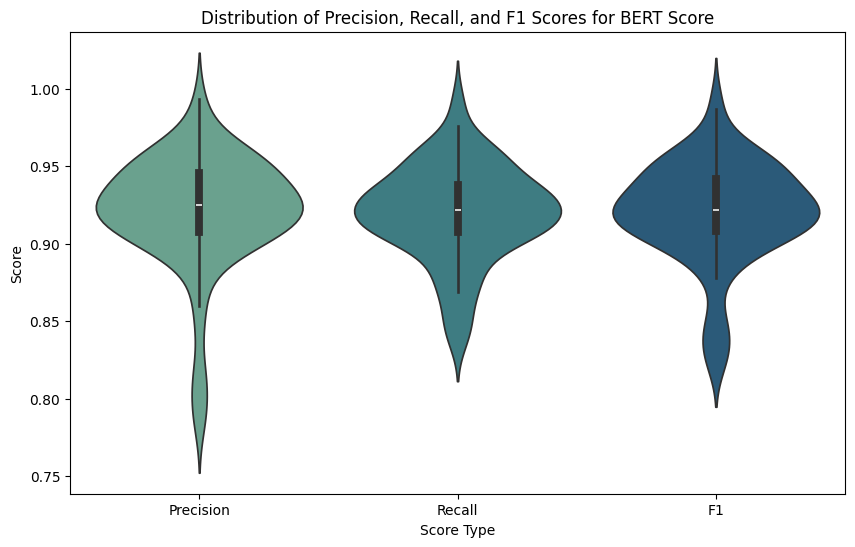

In [120]:
data = pd.DataFrame({
    'Score Type': ['Precision'] * len(precision_scores) + ['Recall'] * len(recall_scores) + ['F1'] * len(f1_scores),
    'Score': precision_scores + recall_scores + f1_scores
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Score Type", y="Score", data=data, palette="crest", hue="Score Type")
plt.title('Distribution of Precision, Recall, and F1 Scores for BERT Score')
plt.ylabel('Score')
plt.show()

### Analyzing BERT Score

BERT Score is a translation evaluation metric that considers semantic similarity by comparing embeddings of text segments rather than relying solely on exact word matches. In this way, it much more closely matches human judgement compared to other metrics. This can clearly be seen from the results of the calculation, as the BERT Scores were overall very high compared to the other two metrics.

Based on the results from each of the three metrics, it can be seen that the LLM Translations did succeed in capturing the meaning of the original text, as shown by the high bert score. But it did not manage to closely match the reference translations in the dataset, as shown by the low BLEU Score. More work with fine tuning could be done in the future to potentially increase the scores for BLEU and ROUGE.